In [20]:
import copy 
import os 
import shutil
import itertools
from collections import Counter
import json
import pickle
import pprint
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [6, 8]

# Utility Functions 

In [21]:
def eligible_exps(queries, e_list):
    '''Gets all experiments from e_list with the queries attributes
    param: elist: list of all posible expeirment keys 
    param: queries: list of terms which must be elements of e_list tuples'''
    ret = []
    for exp in e_list:
        flag = True
        for q in queries: 
            if q not in exp:
                flag = False
        if flag:
            ret.append(exp)
    return ret

In [22]:
def norm_ctr(Ctr, n):
    '''Returns sorted list (ctr_name, p) of the n most common elements in Ctr, where p is normalized freq'''
    sort = [list(x) for x in Ctr.most_common(n)]
    norm = len(list(Ctr.elements()))
    for t in sort:
        t[1] = t[1]/norm
    
    return sort 

def add_slist(s1, s2):
    'For all common-keyed tuples in s1-2, add prob values. For new ones, add to returned list'
    s1_keys = [x[0] for x in s1]
    ret = copy.deepcopy(s1)
    
    for t in s2: 
        if t[0] not in s1_keys:
            ret.append(t)
        else:
            for cp in ret:
                if cp[0] == t[0]:
                    cp[1] += t[1]
    return ret
    
def scale_slist(s, nf):
    for t in s:
        t[1] = t[1]/nf
    return s

def sqrt_slist(s):
    for t in s:
        t[1] = np.sqrt(t[1])
    return s

def sqdiff_slist(s1, means):
    '''For every value of m, find the (m, (s-m)^2)'''
    s1_keys = [s[0] for s in s1]
    ret = []
    
    for m in means:
        if m[0] in s1_keys: 
            for s in s1:
                if m[0] == s[0]:
                    ret.append([m[0], ((m[1]-s[1])**2)])
        else:
            ret.append([m[0], (m[1]**2)])
    
    return ret

def mean_slist(all_exps, results):
    '''For all specified experiments, find the list of (CPid, prob) for each and average them'''
    cp = []
    norm = len(all_exps)
    for exp in all_exps: 
        cp = add_slist(cp, norm_ctr(results[exp], None)) #Add the causal predictors to each 
    scaled = scale_slist(cp, norm)
    return sorted(scaled, key=lambda x:x[1], reverse=True)
        

def var_slist(all_exps, results):
    cp = []
    norm = len(all_exps)
    means = mean_slist(all_exps, results)
    
    for exp in all_exps: 
        cp = add_slist(cp, sqdiff_slist(norm_ctr(results[exp], None), means))

    cp = sqrt_slist(scale_slist(cp, norm))
    
    #Sort in same order as means 
    ret = []
    for m in means:
        for e in cp:
            if m[0] == e[0]:
                ret.append(e)
    
    return ret


# Load Data

In [25]:
res_dirs = os.path.join(os.getcwd(), 'processed_results')
results = {}
print(os.listdir(res_dirs))

['.DS_Store', '0413_reddata1000_1000-sample', '0501_reddata5000_5000-sample']


In [27]:
accepted_dirs = ['0413_reddata1000_1000-sample']

for r in os.listdir(res_dirs):
    if r in accepted_dirs:
        pdir = os.path.join(res_dirs, r)
        info = r.split('_')[2]
        
        results[info] =  {}
        results[info]['x_axis'] = pickle.load(open(os.path.join(pdir, 'x_axis'), 'rb'))
        results[info]['y_axis'] = pickle.load(open(os.path.join(pdir, 'y_axis'), 'rb'))
        results[info]['CPid_results'] = pickle.load(open(os.path.join(pdir, 'CPid_results'), 'rb'))
        
print(results.keys())

dict_keys(['1000-sample'])


# Number PCPS Accepted

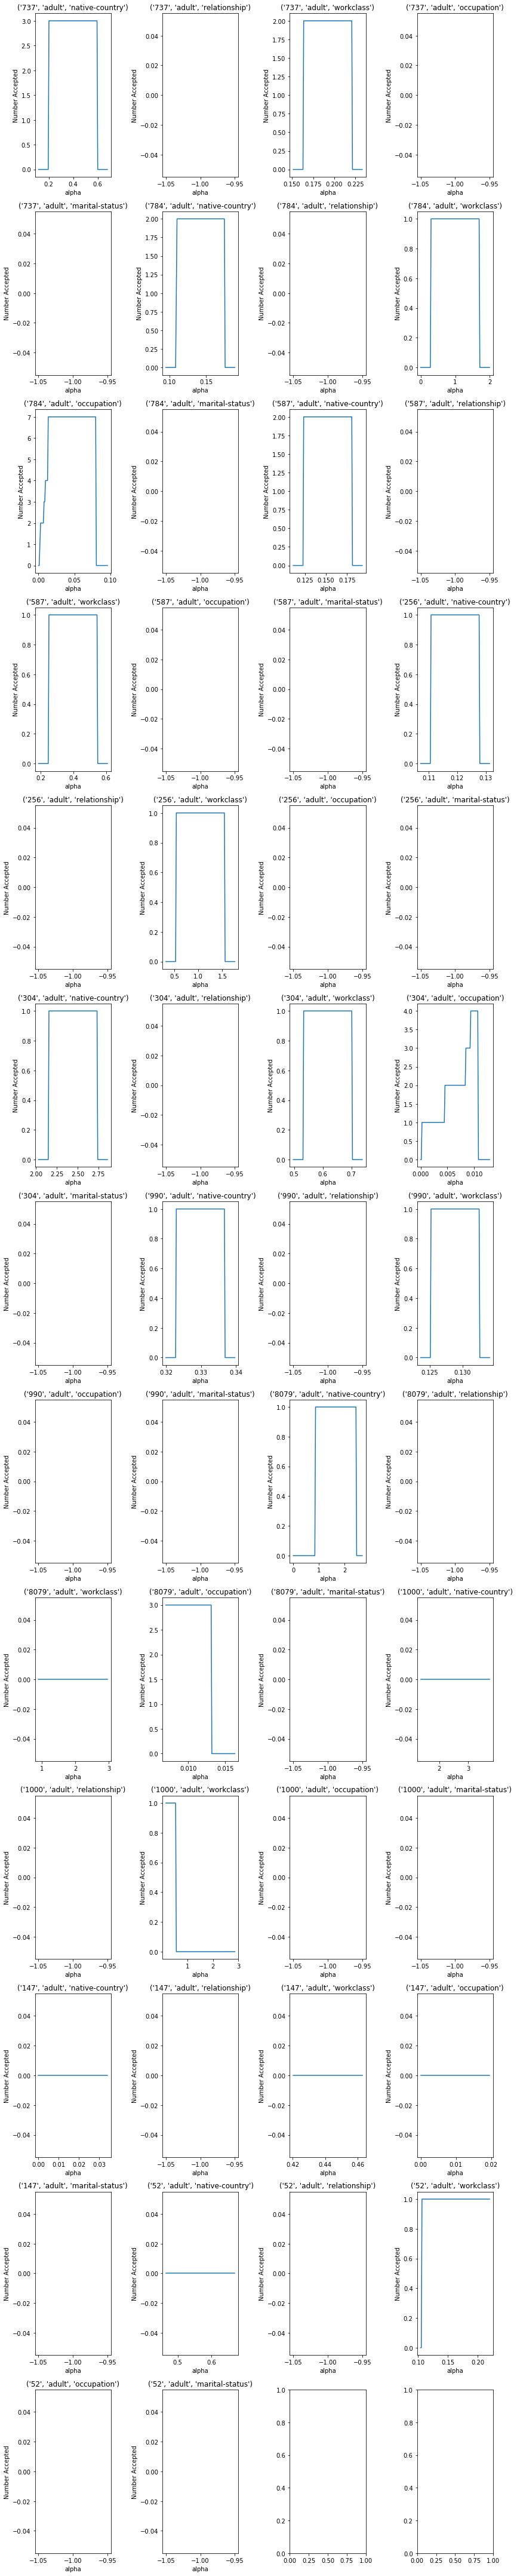

In [28]:
plotting__num_pcps = ['1000-sample']

if len(plotting__num_pcps) > 0:
    NCOLS = 4
    NROWS = int((len(plotting__num_pcps) * 50/NCOLS))
    fig, axes = plt.subplots(NROWS + 1, ncols=NCOLS, figsize=(NCOLS*3, NROWS*5))
    i = 0

    for info in plotting__num_pcps:
        x_axis = results[info]['x_axis']
        y_axis = results[info]['y_axis']

        #Now do plotting
        for exp in x_axis.keys():  #Assume x_axis, y_axis keys are the same 
            axes[int(i/4), i%4].plot(x_axis[exp], y_axis[exp])
            axes[int(i/4), i%4].set_title(exp)
            axes[int(i/4), i%4].set_ylabel('Number Accepted')
            axes[int(i/4), i%4].set_xlabel('alpha')
            i += 1

    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.tight_layout()
    plt.show()


# ALPHA SENSITIVITY PLOTS

##Regular

In [ ]:
# colours = ['b', 'g', 'r', 'c', 'k']
# matplotlib.rcParams.update({'font.size': 16})
# fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 20))

# for i, exp in enumerate(CPid_results.keys()):
#     sort_pcp_sens = norm_ctr(CPid_results[exp], 5)    
    
#     labels = []
#     bars = []
#     for d in range(min(5,len(sort_pcp_sens))):
#         labels.append(sort_pcp_sens[d][0])
#         bars.append(sort_pcp_sens[d][1])


#     X = 0 
#     width = 0.05  # the width of the bars
    
#     axes[int(i/4), i%4].set_title(exp, pad=30)
#     if (i%4) == 0:
#         axes[int(i/4), i%4].set_ylabel('Proportion Included', fontsize=32)
#         axes[int(i/4), i%4].yaxis.labelpad = 40
#     axes[int(i/4), i%4].set_ylim(0,1)
#     axes[int(i/4), i%4].tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False) # labels along the 
    
#     for d in range(len(labels)):
#         axes[int(i/4), i%4].bar(X + (d*width), bars[d], color = colours[d], width = width, label=labels[d])
#     axes[int(i/4), i%4].legend(loc='lower left', prop={'size':30}) 

# plt.show()

In [ ]:
print(CPid_results.keys())

##Aggregate Random Seeds

No handles with labels found to put in legend.
No handles with labels found to put in legend.


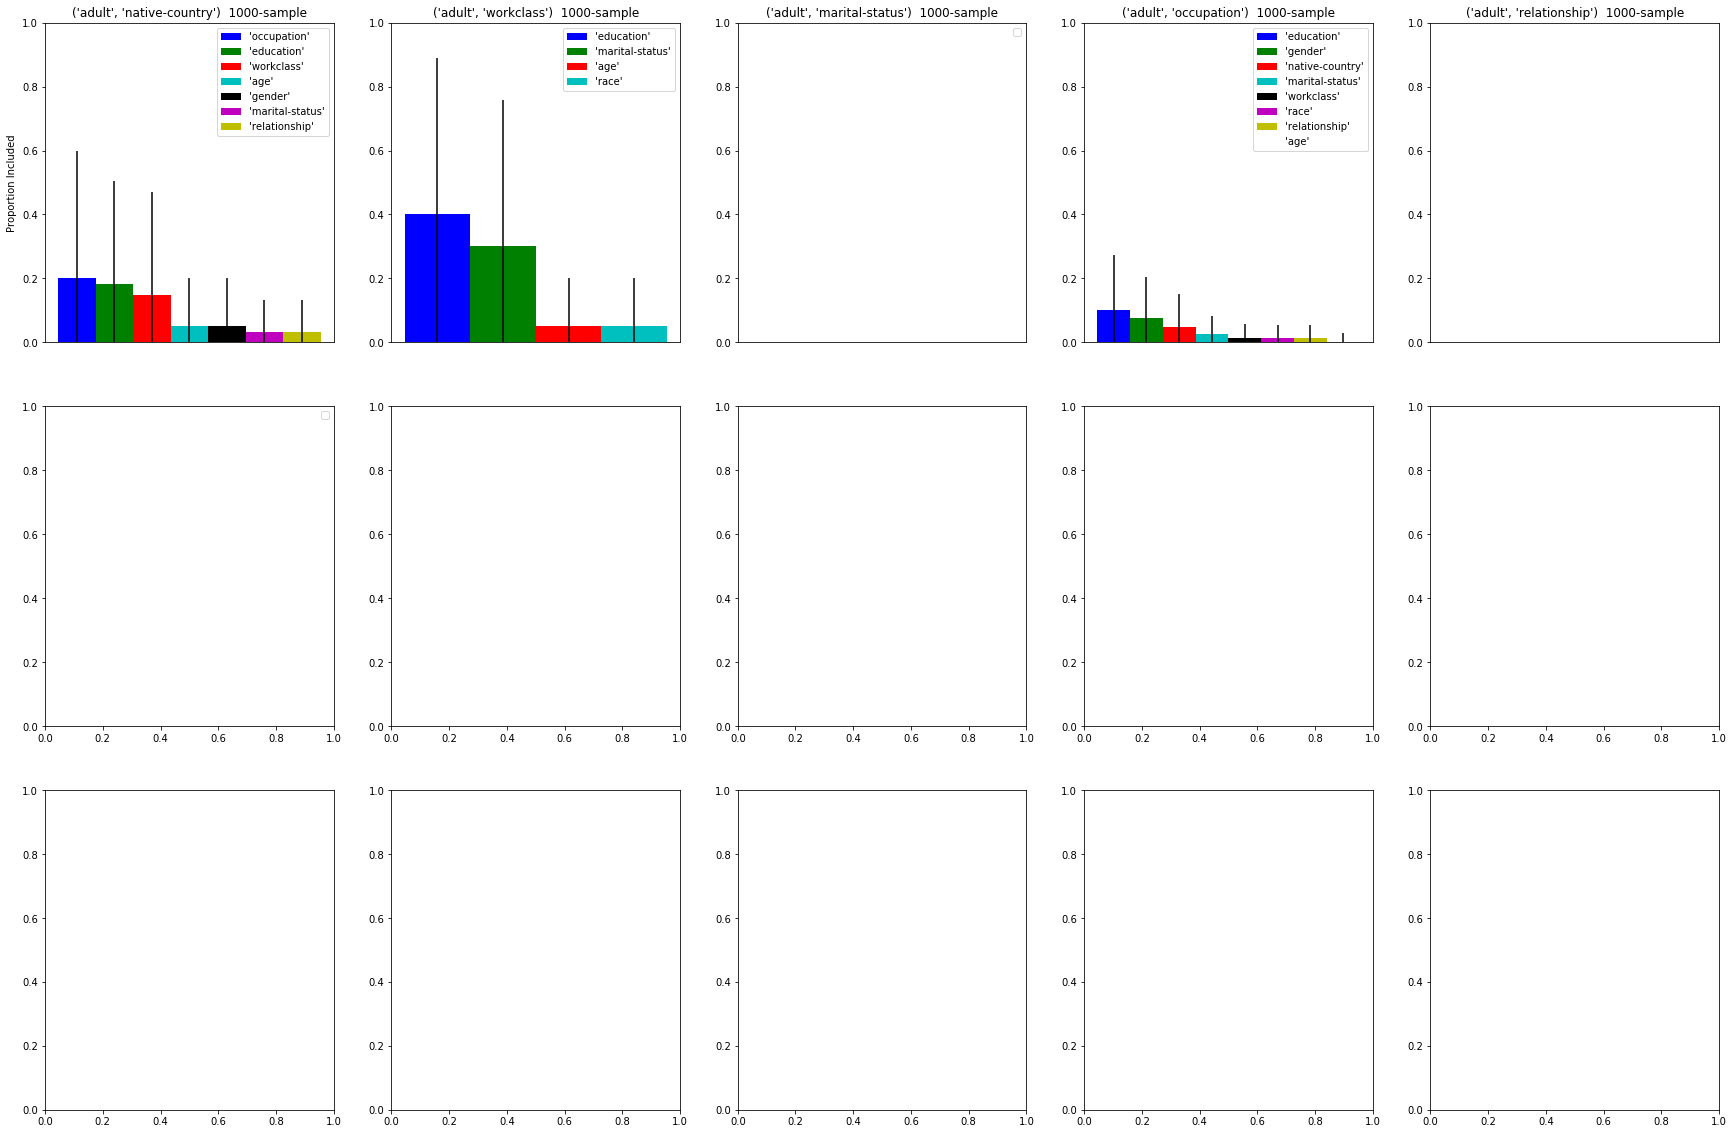

In [34]:
plotting__alpha_sensitivity = ['1000-sample']
dataset = ['adult']
environment = ['native-country', 'workclass', 'marital-status', 'occupation', 'relationship']

if plotting__alpha_sensitivity: 
    colours = ['b', 'g', 'r', 'c', 'k', 'm', 'y', 'w']
    NCOLS = 5
    NROWS = int(10/NCOLS)
    fig, axes = plt.subplots(NROWS + 1, ncols=NCOLS, figsize=(NCOLS*6, NROWS*10))
    
    for dsetres in plotting__alpha_sensitivity:
        for i, big_exp in enumerate(list(itertools.product(dataset, environment))):
            avg_sort_pcp_sens = mean_slist(eligible_exps(big_exp, results[dsetres]['CPid_results'].keys()), \
                                           results[dsetres]['CPid_results'])
            errors = var_slist(eligible_exps(big_exp, results[dsetres]['CPid_results'].keys()), results[dsetres]['CPid_results'])

            labels = []
            bars = []
            errors_plt = []
            for d in range(min(8,len(avg_sort_pcp_sens))):
                labels.append(avg_sort_pcp_sens[d][0])
                bars.append(avg_sort_pcp_sens[d][1])
                errors_plt.append(errors[d][1])

            X = 0 
            width = 0.05  # the width of the bars

            axes[int(i/NCOLS), i%NCOLS].set_title('{}  {}'.format(big_exp, dsetres))  #, pad=30)
            if (i%NCOLS) == 0:
                axes[int(i/NCOLS), i%NCOLS].set_ylabel('Proportion Included') #, fontsize=32)
                axes[int(i/NCOLS), i%NCOLS].yaxis.labelpad = 5
            axes[int(i/NCOLS), i%NCOLS].set_ylim(0,1)
            axes[int(i/NCOLS), i%NCOLS].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the 

            for d in range(len(labels)):
                axes[int(i/4), i%4].bar(X + (d*width), bars[d], color = colours[d], \
                                        width = width, label=labels[d], yerr=errors_plt[d])
            axes[int(i/4), i%4].legend(loc='upper right')  #, prop={'size':30}) 

    plt.show()

## Confusion Matrix

In [31]:
###Note - has not yet been adapted 

all_consmats = []  #consmats for all (dataset, seed) combos

#Get the consistency matrix for each seed
for big_exp in list(itertools.product(dataset, seed)):  #enumerates through each random seed 
    env_exps = eligible_exps(big_exp, CPid_results.keys())
    res = np.zeros([len(environment), len(environment)])
    for i, env_1 in enumerate(env_exps):
        for j, env_2 in enumerate(env_exps):
            if i <= j:
                e1 = set([x[0] for x in norm_ctr(CPid_results[env_1], 5)])
                e2 = set([x[0] for x in norm_ctr(CPid_results[env_2], 5)])
                #Jaccard
                if (len(set.intersection(e1, e2)) == 0) and (len(set.union(e1, e2)) == 0):
                    res[i,j] = 1
                else:
                    res[i,j] = len(set.intersection(e1, e2))/len(set.union(e1, e2))

    all_consmats.append(res)

#Compute mean, variance of consistency matrix 
mean_consmat = (sum(all_consmats)/len(all_consmats)).round(decimals=2)
std_consmat = np.zeros([len(environment), len(environment)])
for cm in all_consmats:
    std_consmat += np.square((cm - mean_consmat))
std_consmat = np.sqrt(std_consmat/len(all_consmats)).round(decimals=2)

consmat = pd.DataFrame(mean_consmat, index=environment, columns=environment).applymap(str).apply( \
              lambda x: x + ' +- ') + pd.DataFrame(std_consmat, index=environment, columns=environment).applymap(str)  
consmat.style





,native-country,relationship,workclass,occupation,marital-status
native-country,1.0 +- 0.0,0.0 +- 0.0,0.11 +- 0.12,0.0 +- 0.0,0.0 +- 0.0
relationship,0.0 +- 0.0,1.0 +- 0.0,0.0 +- 0.0,1.0 +- 0.0,1.0 +- 0.0
workclass,0.0 +- 0.0,0.0 +- 0.0,1.0 +- 0.0,0.0 +- 0.0,0.0 +- 0.0
occupation,0.0 +- 0.0,0.0 +- 0.0,0.0 +- 0.0,1.0 +- 0.0,1.0 +- 0.0
marital-status,0.0 +- 0.0,0.0 +- 0.0,0.0 +- 0.0,0.0 +- 0.0,1.0 +- 0.0
